In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Try reading the file while skipping problematic rows
try:
    df = pd.read_csv('/content/DisneylandReviews.csv', encoding='latin-1', na_values='missing')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
    # Identify the problematic rows causing the error
    with open('/content/DisneylandReviews.csv', 'r', encoding='latin-1') as file:
        lines = file.readlines()
        problematic_rows = [i+1 for i, line in enumerate(lines) if 'EOF inside string' in line]
        print(f"Problematic rows: {problematic_rows}")
    # Skip problematic rows and attempt to read the file again
    df = pd.read_csv('/content/DisneylandReviews.csv', encoding='latin-1', na_values='missing', skiprows=problematic_rows)


# **Exploratory Data Analysis**

In [3]:
df.shape # in the form of (rows,cols)

(42656, 6)

In [4]:
df.describe() # to display different statistical measures of the dataset

,Review_ID,Rating
count,4.265600e+04,42656.000000
mean,3.188553e+08,4.217695
std,1.657092e+08,1.063371
min,1.398724e+06,1.000000
25%,1.743274e+08,4.000000
50%,2.907583e+08,5.000000
75%,4.489579e+08,5.000000
max,6.708014e+08,5.000000


In [5]:
df.info() # to display full summary of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         40043 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [6]:
# checking for NaN values if any
print(df.isna().sum())

Review_ID               0
Rating                  0
Year_Month           2613
Reviewer_Location       0
Review_Text             0
Branch                  0
dtype: int64


In [7]:
# finding out columns with null values
df.columns[df.isnull().any()].tolist()

['Year_Month']

In [8]:
df.dropna(inplace = True) # drop those columns

In [9]:
df.isnull().sum()

Review_ID            0
Rating               0
Year_Month           0
Reviewer_Location    0
Review_Text          0
Branch               0
dtype: int64

In [10]:
df.drop_duplicates(subset="Review_ID",inplace=True,keep='first') # removing duplicate label from Review_ID column

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40023 entries, 0 to 42117
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          40023 non-null  int64 
 1   Rating             40023 non-null  int64 
 2   Year_Month         40023 non-null  object
 3   Reviewer_Location  40023 non-null  object
 4   Review_Text        40023 non-null  object
 5   Branch             40023 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


In [12]:
# separating year and month from Year_month columns to two separate columns
timeline = df['Year_Month'].str.split('-')
df['Year'] = timeline.str[0]
df['Month'] = timeline.str[1]
df.drop(["Year_Month"], axis = 1, inplace = True)
df.head()

,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month
0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4
1,670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5
2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4
3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4
4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4


In [13]:
#Name of all countries in dataset

li=list((df['Reviewer_Location'].value_counts()).index)
li

['United States',
 'United Kingdom',
 'Australia',
 'Canada',
 'India',
 'Philippines',
 'Singapore',
 'New Zealand',
 'Malaysia',
 'Hong Kong',
 'Indonesia',
 'Ireland',
 'United Arab Emirates',
 'Netherlands',
 'South Africa',
 'France',
 'Thailand',
 'Germany',
 'China',
 'Belgium',
 'Spain',
 'Italy',
 'Switzerland',
 'Mexico',
 'Saudi Arabia',
 'Israel',
 'Greece',
 'Norway',
 'Portugal',
 'Brazil',
 'Sweden',
 'Romania',
 'Denmark',
 'Malta',
 'Egypt',
 'Qatar',
 'Japan',
 'Finland',
 'Lebanon',
 'Vietnam',
 'Turkey',
 'Cyprus',
 'Russia',
 'Kuwait',
 'Bahrain',
 'South Korea',
 'Macau',
 'Taiwan',
 'Sri Lanka',
 'Austria',
 'Mauritius',
 'Czechia',
 'Iran',
 'Argentina',
 'Poland',
 'Pakistan',
 'Oman',
 'Hungary',
 'Nigeria',
 'Brunei',
 'Chile',
 'Puerto Rico',
 'Croatia',
 'Bulgaria',
 'Kenya',
 'Guam',
 'Jersey',
 'Bangladesh',
 'Luxembourg',
 'Peru',
 'Colombia',
 'Serbia',
 'Costa Rica',
 'Slovakia',
 'Estonia',
 'Gibraltar',
 'Jordan',
 'Guernsey',
 'Ukraine',
 'Isle of M

In [14]:
df.reset_index(inplace=True)

In [15]:
df.shape

(40023, 8)

# **Text Preprocessing**

In [16]:
#Random record in Review_Text
df['Review_Text'][726]

'I went to HK Disneyland from Wanchai on a rainy Friday afternoon. It was easy to get to on the MTR. The park was not too crowded and lines were fairly short. For some reason the Jungle Cruise line was longer than any other I waited for! Lucky for me they had a line for English speaking and the    river guide    spoke in clear English. Which is more than could be said for the train conductor whose English was indistinguishable from her Chinese. The castle was under construction but I was informed of that before I paid. I had a wonderful afternoon and four hours was plenty. '

###**Punctuation Removal**

In [17]:
new_review1 = []
for i in range(len(df['Review_Text'])):
    review1=re.sub('[^a-zA-Z]', ' ', df['Review_Text'][i])
    new_review1.append(review1)

In [18]:
new_review1[726]

'I went to HK Disneyland from Wanchai on a rainy Friday afternoon  It was easy to get to on the MTR  The park was not too crowded and lines were fairly short  For some reason the Jungle Cruise line was longer than any other I waited for  Lucky for me they had a line for English speaking and the    river guide    spoke in clear English  Which is more than could be said for the train conductor whose English was indistinguishable from her Chinese  The castle was under construction but I was informed of that before I paid  I had a wonderful afternoon and four hours was plenty  '

###**Whitespace Removal**

In [19]:
new_review2 = []
for i in range(len(new_review1)):
    review2=new_review1[i].strip()
    new_review2.append(review2)

In [20]:
new_review2[726]

'I went to HK Disneyland from Wanchai on a rainy Friday afternoon  It was easy to get to on the MTR  The park was not too crowded and lines were fairly short  For some reason the Jungle Cruise line was longer than any other I waited for  Lucky for me they had a line for English speaking and the    river guide    spoke in clear English  Which is more than could be said for the train conductor whose English was indistinguishable from her Chinese  The castle was under construction but I was informed of that before I paid  I had a wonderful afternoon and four hours was plenty'

###**Lowercase Conversion**

In [21]:
new_review3 = []
for i in range(len(new_review2)):
    review3=new_review2[i].lower()
    new_review3.append(review3)

In [22]:
new_review3[726]

'i went to hk disneyland from wanchai on a rainy friday afternoon  it was easy to get to on the mtr  the park was not too crowded and lines were fairly short  for some reason the jungle cruise line was longer than any other i waited for  lucky for me they had a line for english speaking and the    river guide    spoke in clear english  which is more than could be said for the train conductor whose english was indistinguishable from her chinese  the castle was under construction but i was informed of that before i paid  i had a wonderful afternoon and four hours was plenty'

###**Stopword Removal**

In [23]:
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation
name = ['disney', 'disneyland', 'iron', 'ironman', 'mickey', 'buz', 'hk', 'california', 'paris', 'hongkong']

new_review4 = []

for i in new_review3:
    sentence = i.split()
    s_p=[]
    for cor in sentence:
        if cor not in stop_words and cor not in punctuation and cor not in name:
            s_p.append(cor)
    s_p=" ".join(s_p)
    new_review4.append(s_p)

In [24]:
new_review4[726]

'went wanchai rainy friday afternoon easy get mtr park crowded lines fairly short reason jungle cruise line longer waited lucky line english speaking river guide spoke clear english could said train conductor whose english indistinguishable chinese castle construction informed paid wonderful afternoon four hours plenty'

###**Stemming**

In [25]:
porter = PorterStemmer()

for stemmer in (porter,):
    new_review5 = [stemmer.stem(t) for t in new_review4]


In [26]:
new_review5[726]

'went wanchai rainy friday afternoon easy get mtr park crowded lines fairly short reason jungle cruise line longer waited lucky line english speaking river guide spoke clear english could said train conductor whose english indistinguishable chinese castle construction informed paid wonderful afternoon four hours plenti'

###**Lemmatization and POS Tagging**

In [27]:
n=WordNetLemmatizer()
new_review6=[]
for i in range(len(new_review5)):
    words=word_tokenize(new_review5[i])
    lem_word=[]
    for w in words:
        lemm=n.lemmatize(w)
        lem_word.append(lemm)
    ps_tg=pos_tag(lem_word)
    new_review6.append(ps_tg)

In [28]:
new_review6[726]

[('went', 'VBD'),
 ('wanchai', 'JJ'),
 ('rainy', 'NN'),
 ('friday', 'JJ'),
 ('afternoon', 'NN'),
 ('easy', 'JJ'),
 ('get', 'VB'),
 ('mtr', 'JJ'),
 ('park', 'NN'),
 ('crowded', 'VBD'),
 ('line', 'NN'),
 ('fairly', 'RB'),
 ('short', 'JJ'),
 ('reason', 'NN'),
 ('jungle', 'NN'),
 ('cruise', 'NN'),
 ('line', 'NN'),
 ('longer', 'RB'),
 ('waited', 'VBD'),
 ('lucky', 'JJ'),
 ('line', 'NN'),
 ('english', 'JJ'),
 ('speaking', 'NN'),
 ('river', 'NN'),
 ('guide', 'RB'),
 ('spoke', 'VBD'),
 ('clear', 'JJ'),
 ('english', 'NN'),
 ('could', 'MD'),
 ('said', 'VBD'),
 ('train', 'VB'),
 ('conductor', 'NN'),
 ('whose', 'WP$'),
 ('english', 'JJ'),
 ('indistinguishable', 'JJ'),
 ('chinese', 'JJ'),
 ('castle', 'NN'),
 ('construction', 'NN'),
 ('informed', 'VBN'),
 ('paid', 'VBN'),
 ('wonderful', 'JJ'),
 ('afternoon', 'NN'),
 ('four', 'CD'),
 ('hour', 'NN'),
 ('plenti', 'NN')]

###**Processed Review Text Concatenation**

In [29]:
new_review7 = [[tup[0] for tup in sublist] for sublist in new_review6]
text=[]
for i in new_review7 :
    lem_join=" ".join(i)
    text.append(lem_join)

In [30]:
text[726]

'went wanchai rainy friday afternoon easy get mtr park crowded line fairly short reason jungle cruise line longer waited lucky line english speaking river guide spoke clear english could said train conductor whose english indistinguishable chinese castle construction informed paid wonderful afternoon four hour plenti'

In [31]:
df["Extracted_review"] = text

In [32]:
df.head()

,index,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month,Extracted_review
0,0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,ever anywhere find hong kong similar layout wa...
1,1,670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,since last time visit yet time stay tomorrowla...
2,2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,thanks god hot humid visiting park otherwise w...
3,3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,great compact park unfortunately quite bit mai...
4,4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,location city took around hour kowlon kid like...


###**Parsing**

In [33]:
import spacy
from spacy import displacy

In [34]:
# Load the English language model
nlp = spacy.load("en_core_web_sm")

In [35]:
#Create a list of every word in the Extracted_Review column and its tag
tags = set()

for sublist in new_review6:
    for element in sublist:
        tags.add(element)

# Convert set to list if necessary
tags = list(tags)


In [36]:
tags

[('extortious', 'JJ'),
 ('puzzle', 'RB'),
 ('supplement', 'VBD'),
 ('addition', 'NN'),
 ('sooo', 'VBD'),
 ('spendy', 'NN'),
 ('tattoo', 'VBP'),
 ('proof', 'VBP'),
 ('anntets', 'NNS'),
 ('kong', 'JJ'),
 ('october', 'VBP'),
 ('slinky', 'NN'),
 ('vitamin', 'JJ'),
 ('vica', 'NN'),
 ('afterwards', 'VBZ'),
 ('unyielding', 'JJ'),
 ('timesyet', 'NN'),
 ('allergic', 'JJ'),
 ('locked', 'VBD'),
 ('gondola', 'JJ'),
 ('buildingsmoving', 'VBG'),
 ('catch', 'VB'),
 ('putting', 'VBG'),
 ('moved', 'VB'),
 ('vey', 'NNS'),
 ('astonishing', 'JJ'),
 ('disneyworld', 'VB'),
 ('planning', 'JJ'),
 ('coastermystic', 'JJ'),
 ('length', 'RB'),
 ('impede', 'VBP'),
 ('elysees', 'VBZ'),
 ('height', 'JJ'),
 ('screamed', 'VBN'),
 ('daunting', 'VBG'),
 ('married', 'VBD'),
 ('dinosaur', 'VBP'),
 ('registered', 'JJ'),
 ('gambl', 'NN'),
 ('youd', 'NN'),
 ('temper', 'NN'),
 ('veal', 'VBP'),
 ('spread', 'RB'),
 ('mango', 'NN'),
 ('threshold', 'JJ'),
 ('enron', 'NN'),
 ('voucherstake', 'VBP'),
 ('earnest', 'JJS'),
 ('segrega

Constructing a dependency tree for *tags* is not feasible as it will require much more compute power than supported by Google Colab. The example below shows how the parse tree would look like for the tagset of one random record from *Extracted_Reviews*.

In [37]:
# Convert the list of tuples to a sentence
sentence = ' '.join([word for word, pos in new_review6[726]])


In [38]:
# Process the sentence using spaCy
doc = nlp(sentence)

# Visualize the dependency tree using displacy
displacy.render(doc, style='dep', jupyter=True)

Parsing every extracted review and finding meaningful relationships will be another great computational expense. It also does not really contribute to the model building or sentiment analysis part in any way. So, it has been shown here for the first 100 reviews' tagsets alone.

In [39]:
for i in range(1,100):
  sentence = ' '.join([word for word, pos in new_review6[i]])
  doc=nlp(sentence)
  print(f"Review {i+1}")
  # Extract meaningful syntactic patterns or structures from the parse tree
  for token in doc:
      print(f"Token: {token.text}, POS: {token.pos_}, Dependency: {token.dep_}, Head: {token.head.text}")

  # Example of extracting meaningful syntactic patterns:
  # Extracting noun phrases (NPs)
  noun_phrases = [chunk.text for chunk in doc.noun_chunks]
  print("\nNoun Phrases:")
  for np in noun_phrases:
      print(np)

Streaming output truncated to the last 5000 lines.
Token: could, POS: AUX, Dependency: aux, Head: find
Token: find, POS: VERB, Dependency: ccomp, Head: want
Token: map, POS: NOUN, Dependency: compound, Head: place
Token: place, POS: NOUN, Dependency: dobj, Head: find
Token: priced, POS: VERB, Dependency: acl, Head: place
Token: fun, POS: ADJ, Dependency: amod, Head: character
Token: park, POS: NOUN, Dependency: compound, Head: character
Token: character, POS: NOUN, Dependency: dobj, Head: priced
Token: seen, POS: VERB, Dependency: acl, Head: place
Token: cabana, POS: PROPN, Dependency: compound, Head: visitor
Token: photo, POS: NOUN, Dependency: compound, Head: visitor
Token: visitor, POS: NOUN, Dependency: nmod, Head: rain
Token: queuing, POS: VERB, Dependency: amod, Head: rain
Token: rain, POS: NOUN, Dependency: nsubj, Head: waste
Token: do, POS: AUX, Dependency: aux, Head: waste
Token: nt, POS: PART, Dependency: neg, Head: waste
Token: waste, POS: VERB, Dependency: ccomp, Head: seen

# **Lexicon based Sentiment Analysis using VADER Score**

###**Finding the VADER Score**

In [40]:
senti_analyzer=SentimentIntensityAnalyzer()

In [41]:
df['Rating'][726]

5

In [42]:
df['Extracted_review'][726]

'went wanchai rainy friday afternoon easy get mtr park crowded line fairly short reason jungle cruise line longer waited lucky line english speaking river guide spoke clear english could said train conductor whose english indistinguishable chinese castle construction informed paid wonderful afternoon four hour plenti'

In [43]:
v_scores = []

for i in df['Extracted_review']:
    score = senti_analyzer.polarity_scores(i)
    v_scores.append(score['compound'])

In [44]:
v_scores[726]

0.8934

In [45]:
df['VADER_score'] = v_scores

###**Finding the VADER Polarity**

In [50]:
V_Polarity = []

for i in v_scores:
    if i > 0:
        V_Polarity.append('positive')
    elif i < 0:
        V_Polarity.append('negative')
    else:
        V_Polarity.append('neutral')

In [51]:
V_Polarity[726]

'positive'

In [52]:
df["V_Polarity"] = V_Polarity

In [53]:
df.head()

,index,Review_ID,Rating,Reviewer_Location,Review_Text,Branch,Year,Month,Extracted_review,VADER_score,V_Polarity
0,0,670772142,4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,ever anywhere find hong kong similar layout wa...,0.7070,positive
1,1,670682799,4,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,since last time visit yet time stay tomorrowla...,0.9842,positive
2,2,670623270,4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,thanks god hot humid visiting park otherwise w...,0.9852,positive
3,3,670607911,4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4,great compact park unfortunately quite bit mai...,0.6969,positive
4,4,670607296,4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4,location city took around hour kowlon kid like...,0.5106,positive


# **Data Visualization Using WordCloud**


In [54]:
from PIL import Image
import numpy as np

# loading images which are to be used as masks
positive = np.array(Image.open("/content/positive.png"))
negative = np.array(Image.open("/content/negative.png"))
intermediate = np.array(Image.open("/content/intermediate.png"))


 **WordCloud of Positive Sentiments**

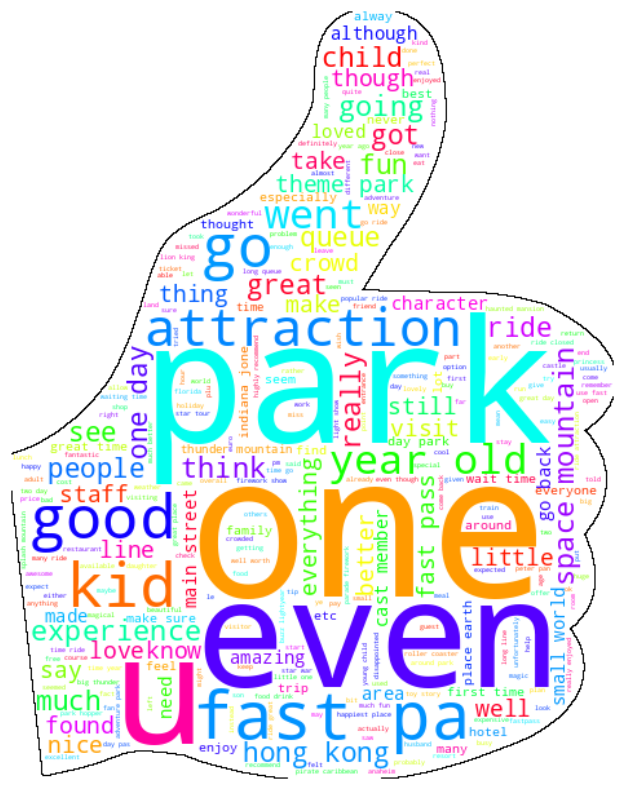

In [56]:
plt.figure(figsize = (10,10))
Wc = WordCloud(mask = positive, background_color='white',
               max_words = 1000 , width = 500 , height = 400,
               contour_width = 1, contour_color = 'black', colormap = "hsv").generate(" ".join(df[df.V_Polarity == "positive"].Extracted_review))
plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

 **WordCloud of Negative Sentiments**

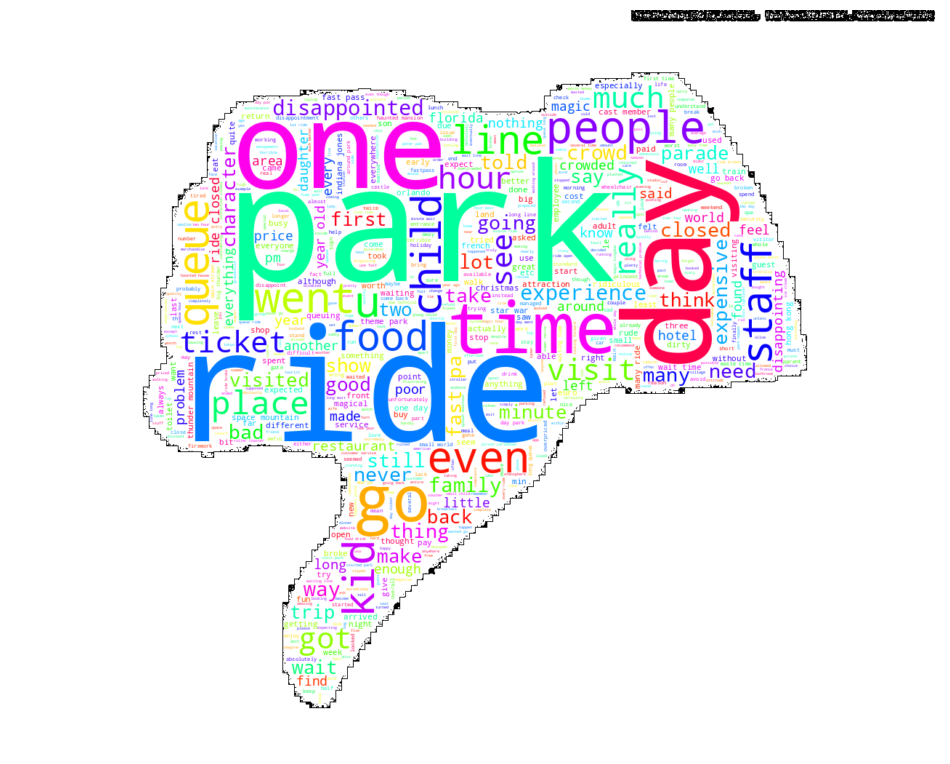

In [58]:
plt.figure(figsize = (12,12))
Wc = WordCloud(mask = negative, background_color='white',
               max_words = 1000 , width = 500 , height = 400,
               contour_width = 1, contour_color = 'black', colormap = "hsv").generate(" ".join(df[df.V_Polarity=="negative"].Extracted_review))
plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

**WordCloud of Intermediate Sentiments**

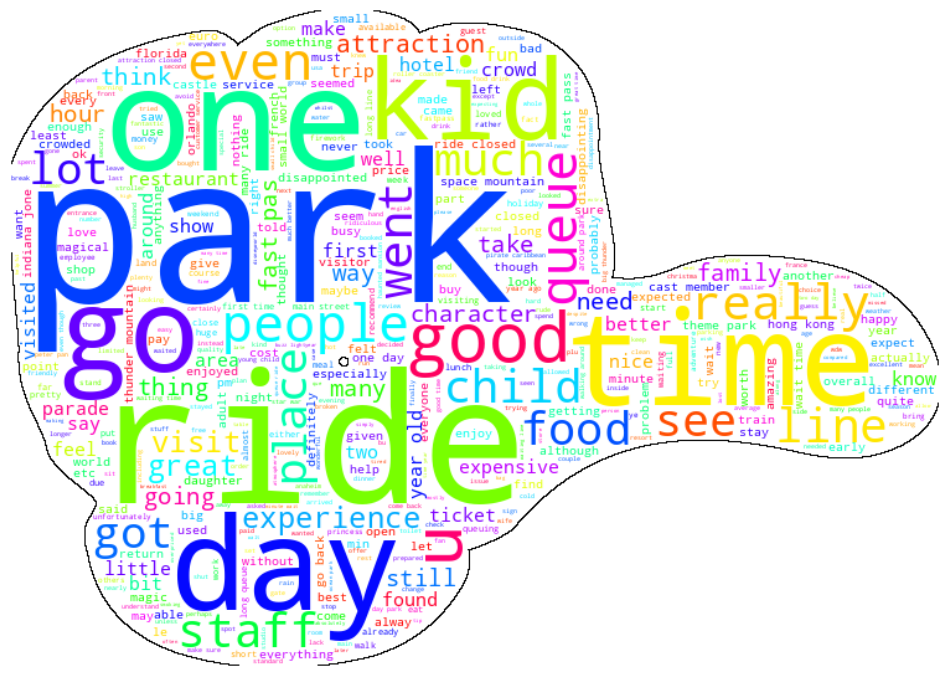

In [62]:
plt.figure(figsize = (12,12))
Wc = WordCloud(mask = intermediate, background_color='white',
               max_words = 1000 , width = 500 , height = 400,
               contour_width = 1, contour_color = 'black', colormap = "hsv").generate(" ".join(df[df.Rating == 3].Extracted_review))
plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

# **Model Building and Testing**

###**Identifying Feature Matrix and Target Variable**

In [69]:
X = df['Extracted_review']
X

0        ever anywhere find hong kong similar layout wa...
1        since last time visit yet time stay tomorrowla...
2        thanks god hot humid visiting park otherwise w...
3        great compact park unfortunately quite bit mai...
4        location city took around hour kowlon kid like...
                               ...                        
40018    although pick prompt taxi driver wasnt sure ti...
40019    returned day family trip two boy aged reading ...
40020    spent dec park lunchtime attraction starting c...
40021    well really looking forward trip christmas per...
40022    staying hotel make good use extra hour fast pa...
Name: Extracted_review, Length: 40023, dtype: object

In [70]:
X.shape

(40023,)

In [71]:
y = df['V_Polarity']
y

0        2
1        2
2        2
3        2
4        2
        ..
40018    0
40019    2
40020    2
40021    2
40022    2
Name: V_Polarity, Length: 40023, dtype: int64

In [72]:
y.shape

(40023,)

###**Splitting the data**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

print(X_train.shape, X_test.shape)
np.unique(y_train, return_counts=True)

(32018,) (8005,)


(array([0, 1, 2]), array([ 2341,   403, 29274]))

###**Using Tf-IDF Vectorizer**

In [74]:
stop_words = stopwords.words('english')

vect = TfidfVectorizer(stop_words=stop_words).fit(X_train)
X_train_vectorized = vect.transform(X_train)

X_train_vectorized

<32018x30560 sparse matrix of type '<class 'numpy.float64'>'
	with 1562391 stored elements in Compressed Sparse Row format>

In [75]:
X_train_vectorized.shape

(32018, 30560)

### **Using Decision Tree classifier**

In [109]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_vectorized, y_train)
print("Train accuracy: ", nb.score(X_train_vectorized, y_train))
print("Test accuracy: ", nb.score(vect.transform(X_test), y_test))


Train accuracy:  0.9142982072584172
Test accuracy:  0.9143035602748283


### **Using Random Forest classifier**

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 100, random_state = 42)
rf.fit(X_train_vectorized, y_train)
print("Train accuracy: ",rf.score(X_train_vectorized, y_train))
print("Test accuracy: ",rf.score(vect.transform(X_test), y_test))

Train accuracy:  0.9580860765819227
Test accuracy:  0.9144284821986258


### **Using CNN**

In [100]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.sequence import pad_sequences

In [101]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=62482)

tokenizer.fit_on_texts(X_train)

X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

In [102]:
# Define the maximum number of words in a sentence
max_words = 100

# Pad sequences to ensure uniform input length
X_train_pad = pad_sequences(X_train_sequence, maxlen=max_words)
X_test_pad = pad_sequences(X_test_sequence, maxlen=max_words)

In [103]:
import tensorflow as tf

# Clear the TensorFlow default graph
tf.keras.backend.clear_session()

In [104]:
# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=62482, output_dim=100, input_length=max_words))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

In [105]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
from keras.utils import to_categorical

# Convert target labels to one-hot encoded format
y_train_one_hot = to_categorical(y_train, 3)
y_test_one_hot = to_categorical(y_test, 3)


In [108]:
# Train the model with one-hot encoded target labels
model.fit(X_train_pad, y_train_one_hot, epochs=3, batch_size=32, validation_data=(X_test_pad, y_test_one_hot))


Epoch 1/3
1001/1001 [==============================] - 113s 113ms/step - loss: 0.1970 - accuracy: 0.9282 - val_loss: 0.1734 - val_accuracy: 0.9374
Epoch 2/3
1001/1001 [==============================] - 116s 116ms/step - loss: 0.0938 - accuracy: 0.9665 - val_loss: 0.1733 - val_accuracy: 0.9399
Epoch 3/3
1001/1001 [==============================] - 124s 124ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.2830 - val_accuracy: 0.9379
